In [3]:
!pip install prophet

  Using cached prophet-1.1.5-py3-none-macosx_10_9_x86_64.whl.metadata (3.5 kB)
  Using cached cmdstanpy-1.2.4-py3-none-any.whl.metadata (4.1 kB)
  Using cached holidays-0.52-py3-none-any.whl.metadata (23 kB)
  Using cached stanio-0.5.0-py3-none-any.whl.metadata (1.3 kB)
Using cached prophet-1.1.5-py3-none-macosx_10_9_x86_64.whl (8.8 MB)
Using cached cmdstanpy-1.2.4-py3-none-any.whl (94 kB)
Using cached holidays-0.52-py3-none-any.whl (1.0 MB)
Using cached stanio-0.5.0-py3-none-any.whl (8.0 kB)


In [4]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import ParameterGrid

warnings.filterwarnings(action='ignore')

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
origin_df = pd.read_csv("특별자치구.csv", parse_dates=['YMD_CD'], index_col=0)
item_mst1 = pd.read_csv('ITEM_MST.txt', encoding='cp949', sep='|')
item_mst2 = pd.read_csv('ITEM_MST2.txt', encoding='cp949', sep='|')
item_mst = pd.concat([item_mst1, item_mst2], ignore_index=True)

In [7]:
# 아이템 이름 붙이기
temp_subset = item_mst[['ITEM_CD', 'ITEM_NM']]
origin_df = origin_df.merge(temp_subset, on='ITEM_CD', how='left')

In [8]:
# 판매량 제로 아이템 제거
sale_sum = origin_df.groupby('ITEM_CD').agg({"SALE_QTY":"sum"})
zero_items = list(sale_sum[sale_sum['SALE_QTY']==0].index)
origin_df = origin_df[~origin_df['ITEM_CD'].isin(zero_items)]

In [9]:

def plot_prophet(origin_df: pd.DataFrame, prst_no: int, item_cd: int):
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    model = Prophet()
    
    features = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'WEEKDAY', 
                'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
                'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7']
    
    for feature in features:
        if feature in train_prophet.columns:
            model.add_regressor(feature)
    
    model.fit(train_prophet)
    
    # 예측 설정
    future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    
    # 미래 데이터프레임에 추가 특성들 포함
    future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
    future_with_features = future_with_features.drop(columns=['YMD_CD'])
    
    forecast = model.predict(future_with_features)
    
    # 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_train['YMD_CD'], filtered_train['SALE_QTY'], label='Train Sales')
    plt.plot(filtered_test['YMD_CD'], filtered_test['SALE_QTY'], label='Test Sales')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
    plt.plot(forecast['ds'], forecast['yhat_upper'], label='Upper Confidence Interval', linestyle='--')
    plt.plot(forecast['ds'], forecast['yhat_lower'], label='Lower Confidence Interval', linestyle='--')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
    plt.title('Sales Forecast for Jan-Mar 2024 using Prophet')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

# 사용 예시
# plot_prophet(origin_df, prst_no, item_cd)


11:02:59 - cmdstanpy - INFO - Chain [1] start processing
11:03:00 - cmdstanpy - INFO - Chain [1] done processing


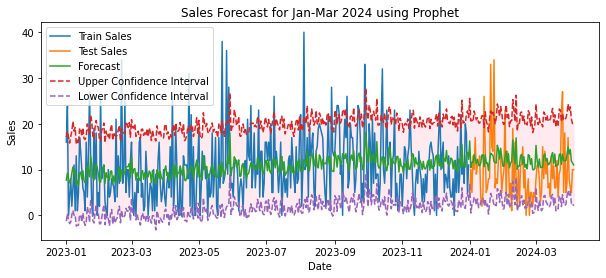

In [10]:
plot_prophet(origin_df, 221327, 8801858011024)

In [11]:
# PRST_NO별 ITEM_CD 기준으로 SALE_QTY를 합산
grouped_df = origin_df.groupby(['PRST_NO', 'ITEM_CD'])['SALE_QTY'].sum().reset_index()

# SALE_QTY 기준으로 내림차순 정렬 후 상위 10개 상품 선택
top_10_items = grouped_df.sort_values(by='SALE_QTY', ascending=False).head(10)

In [12]:
top_10_items

,PRST_NO,ITEM_CD,SALE_QTY
3966,221327,8801858011024,4926
536,34984,8801858011024,4006
1908,122612,8801858011024,3526
3437,221327,88002798,2781
2594,151539,8801858011024,2758
4809,221915,88002798,2694
1777,122612,8801115134237,2676
5338,221915,8801858011024,2649
7,34984,88002798,2495
1379,122612,88002798,2465


17:14:54 - cmdstanpy - INFO - Chain [1] start processing
17:14:54 - cmdstanpy - INFO - Chain [1] done processing


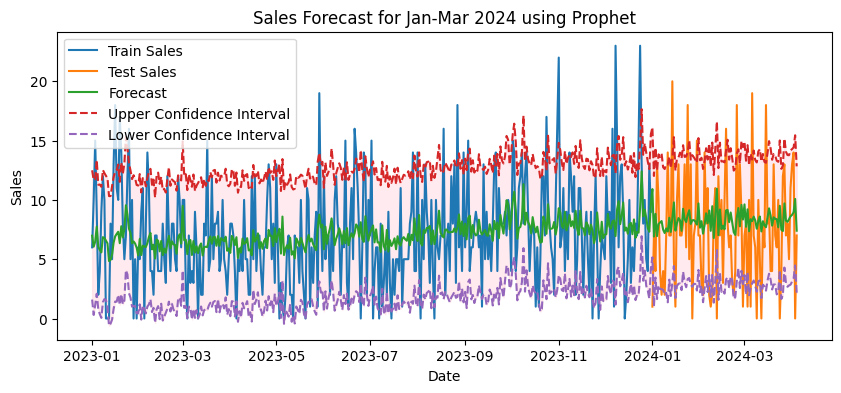

In [22]:
# 카스캔
plot_prophet(origin_df, 122612, 8801858011024)

17:26:12 - cmdstanpy - INFO - Chain [1] start processing
17:26:12 - cmdstanpy - INFO - Chain [1] done processing


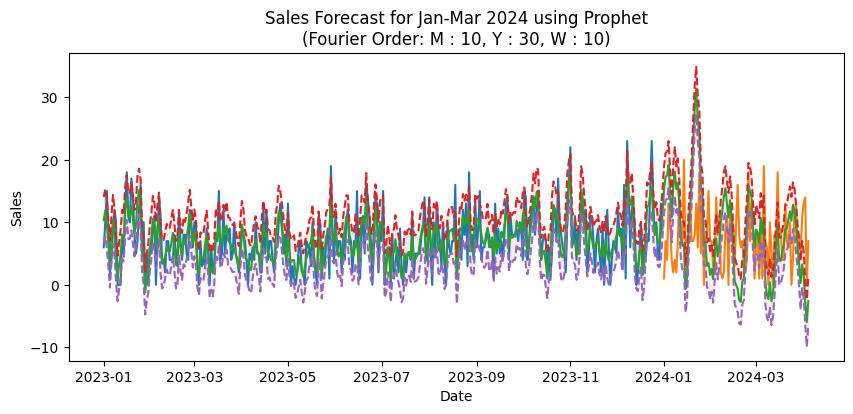

In [37]:
plot_prophet_s(origin_df, 122612, 8801858011024, 10, 30, 10)

In [26]:
plot_prophet(origin_df, 122612, 8801858011024, 5, 10, 30)

TypeError: plot_prophet() takes 3 positional arguments but 6 were given

In [29]:
store_ids = top_10_items['PRST_NO'].unique()
item_cds = top_10_items['ITEM_CD'].unique()

14:06:58 - cmdstanpy - INFO - Chain [1] start processing
14:06:58 - cmdstanpy - INFO - Chain [1] done processing


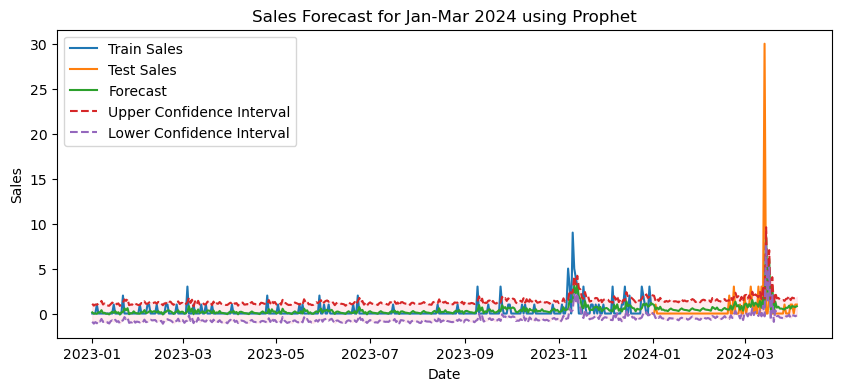

In [32]:
# 빼빼로 아몬드
plot_prophet(origin_df, 221327, 8801062012725)

14:08:05 - cmdstanpy - INFO - Chain [1] start processing
14:08:05 - cmdstanpy - INFO - Chain [1] done processing


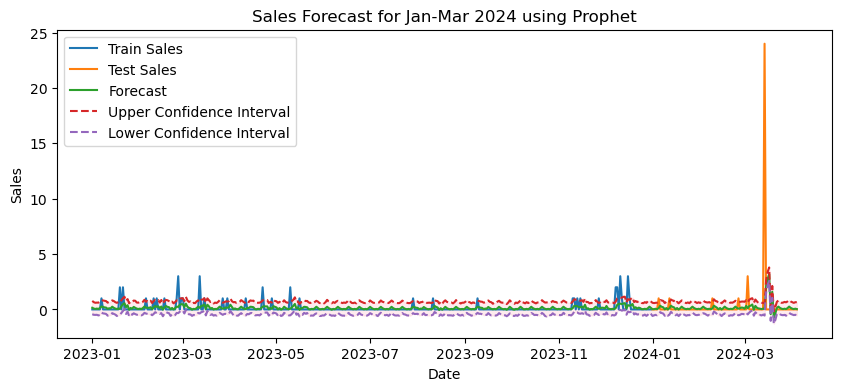

In [33]:
# 빼빼로
plot_prophet(origin_df, 221327, 8801062012732)

14:08:51 - cmdstanpy - INFO - Chain [1] start processing
14:08:51 - cmdstanpy - INFO - Chain [1] done processing


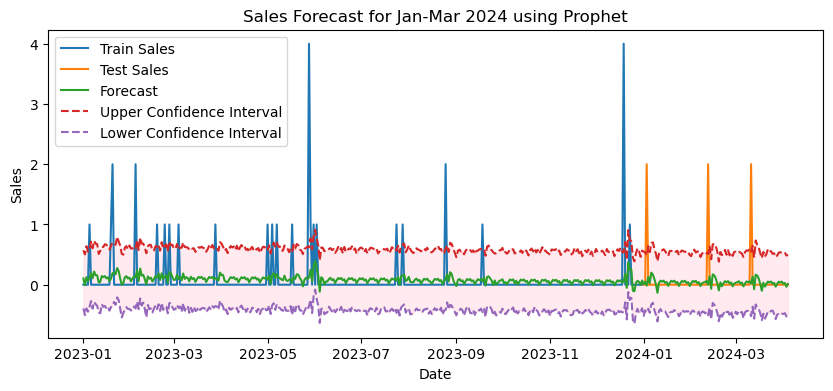

In [34]:
# 블루문 캔
plot_prophet(origin_df, 221327, 4902335060215)

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [16]:
def calculate_metrics(actual, predicted):
    # NRMSE
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    nrmse = rmse / (actual.max() - actual.min())
    
    # NMAE
    mae = mean_absolute_error(actual, predicted)
    nmae = mae / actual.mean()
    
    # R-squared
    r2 = r2_score(actual, predicted)
    
    # MAPE
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    return nrmse, nmae, r2, mape

def plot_prophet(origin_df: pd.DataFrame, prst_no: int, item_cd: int):
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    model = Prophet()
    
    features = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'WEEKDAY', 
                'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
                'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7']
    
    for feature in features:
        if feature in train_prophet.columns:
            model.add_regressor(feature)
    
    model.fit(train_prophet)
    
    # 예측 설정
    future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    
    # 미래 데이터프레임에 추가 특성들 포함
    future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
    future_with_features = future_with_features.drop(columns=['YMD_CD'])
    
    forecast = model.predict(future_with_features)
    
    # 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_train['YMD_CD'], filtered_train['SALE_QTY'], label='Train Sales')
    plt.plot(filtered_test['YMD_CD'], filtered_test['SALE_QTY'], label='Test Sales')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
    plt.plot(forecast['ds'], forecast['yhat_upper'], label='Upper Confidence Interval', linestyle='--')
    plt.plot(forecast['ds'], forecast['yhat_lower'], label='Lower Confidence Interval', linestyle='--')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
    plt.title('Sales Forecast for Jan-Mar 2024 using Prophet')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()
    
    # 성능 지표 계산
    test_actual = filtered_test['SALE_QTY'].values
    test_predicted = forecast.loc[forecast['ds'].isin(filtered_test['YMD_CD']), 'yhat'].values

    nrmse, nmae, r2, mape = calculate_metrics(test_actual, test_predicted)
    
    print(f'NRMSE: {nrmse}')
    print(f'NMAE: {nmae}')
    print(f'R^2: {r2}')
    print(f'MAPE: {mape}')

11:06:18 - cmdstanpy - INFO - Chain [1] start processing
11:06:18 - cmdstanpy - INFO - Chain [1] done processing


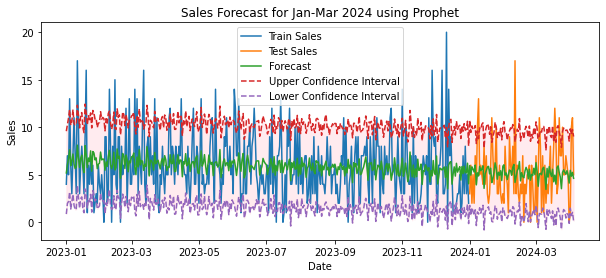

NRMSE: 0.1966245850114244
NMAE: 0.496834582290075
R^2: -0.10132350279595803
MAPE: inf


In [17]:
plot_prophet(origin_df, 221327, 88002798)

17:03:26 - cmdstanpy - INFO - Chain [1] start processing
17:03:26 - cmdstanpy - INFO - Chain [1] done processing


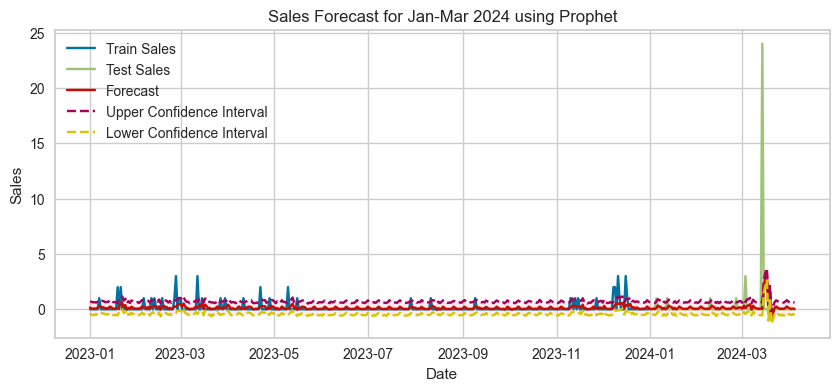

NRMSE: 0.1059149794917414
NMAE: 1.668065003257977
R^2: -0.06039862907259064
MAPE: inf


In [84]:
# 빼빼로
plot_prophet(origin_df, 221327, 8801062012732)

## 체크

In [92]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def plot_prophet_with_r2(origin_df: pd.DataFrame, prst_no: int, item_cd: int):
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    model = Prophet()
    
    features = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'WEEKDAY', 
                'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
                'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7']
    
    for feature in features:
        if feature in train_prophet.columns:
            model.add_regressor(feature)
    
    model.fit(train_prophet)
    
    future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    
    future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
    future_with_features = future_with_features.drop(columns=['YMD_CD'])
    
    forecast = model.predict(future_with_features)
    
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_train['ds'], filtered_train['y'], label='Train Sales')
    plt.plot(filtered_test['ds'], filtered_test['y'], label='Test Sales')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
    plt.plot(forecast['ds'], forecast['yhat_upper'], label='Upper Confidence Interval', linestyle='--')
    plt.plot(forecast['ds'], forecast['yhat_lower'], label='Lower Confidence Interval', linestyle='--')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
    plt.title('Sales Forecast for Jan-Mar 2024 using Prophet')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()
    
    y_test = filtered_test['SALE_QTY'].values
    y_pred = forecast['yhat'].values[:len(filtered_test)]
    
    r2 = r2_score(y_test, y_pred)
    print(f"R-squared (R²) value: {r2}")

    return r2

# Example usage
# Assuming you have a DataFrame named `origin_df` with the necessary columns:
# origin_df = pd.read_csv('your_data.csv')
# plot_prophet_with_r2(origin_df, prst_no=123, item_cd=456)


In [ ]:
# 카스캔
plot_prophet(origin_df, 122612, 8801858011024)

In [ ]:
year_s = #
week_s = #

# **kwargs

In [28]:
def plot_prophet_s(origin_df: pd.DataFrame, prst_no: int, item_cd: int, month_s, year_s=10, week_s=10): 
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    # 모델 마개조 여기서 시작
    model = Prophet(weekly_seasonality=week_s, yearly_seasonality=year_s, daily_seasonality=False)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=month_s)
    
    features = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'WEEKDAY', 
                'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
                'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7']
    
    for feature in features:
        if feature in train_prophet.columns:
            model.add_regressor(feature) # 여기 질문

    model.fit(train_prophet)
    
    # 예측 설정
    future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    
    # 미래 데이터프레임에 추가 특성들 포함
    future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
    future_with_features = future_with_features.drop(columns=['YMD_CD'])
    
    forecast = model.predict(future_with_features)
    
    # 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_train['YMD_CD'], filtered_train['SALE_QTY'], label='Train Sales')
    plt.plot(filtered_test['YMD_CD'], filtered_test['SALE_QTY'], label='Test Sales')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
    plt.plot(forecast['ds'], forecast['yhat_upper'], label='Upper Confidence Interval', linestyle='--')
    plt.plot(forecast['ds'], forecast['yhat_lower'], label='Lower Confidence Interval', linestyle='--')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
    plt.title(f'Sales Forecast for Jan-Mar 2024 using Prophet\n(Fourier Order: M : {month_s}, Y : {year_s}, W : {week_s})')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

In [ ]:
plot_prophet

In [19]:
def plot_prophet_test(origin_df: pd.DataFrame, prst_no: int, item_cd: int, month_s, year_s=10, week_s=10): 
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    # 모델 마개조 여기서 시작
    model = Prophet(weekly_seasonality=week_s, yearly_seasonality=year_s, daily_seasonality=False)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=month_s)
    
    features = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'WEEKDAY', 
                'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
                'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7']
    
    for feature in features:
        if feature in train_prophet.columns:
            model.add_regressor(feature) # 여기 질문

    model.fit(train_prophet)
    
    # 예측 설정
    future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    
    # 미래 데이터프레임에 추가 특성들 포함
    future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
    future_with_features = future_with_features.drop(columns=['YMD_CD'])
    
    forecast = model.predict(future_with_features)
    
    # 2024년도 데이터만 필터링
    filtered_test_2024 = filtered_test[filtered_test['YMD_CD'].dt.year == 2024]
    forecast_2024 = forecast[forecast['ds'].dt.year == 2024]
    
    # 예측 결과와 실제 값 병합
    comparison_df = pd.merge(filtered_test_2024, forecast_2024[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], left_on='YMD_CD', right_on='ds')
    
    # 범위 바깥에 있는 오차 절대값으로 계산
    out_of_bounds_error = 0
    for index, row in comparison_df.iterrows():
        if row['SALE_QTY'] > row['yhat_upper']:
            out_of_bounds_error += abs(row['SALE_QTY'] - row['yhat_upper'])
        elif row['SALE_QTY'] < row['yhat_lower']:
            out_of_bounds_error += abs(row['yhat_lower'] - row['SALE_QTY'])

    
    print('오차범위 바깥의 에러 합계 :', out_of_bounds_error)

    
    # 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_test_2024['YMD_CD'], filtered_test_2024['SALE_QTY'], label='Test Sales')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat'], label='Forecast')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat_upper'], label='Upper Confidence Interval', linestyle='--')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat_lower'], label='Lower Confidence Interval', linestyle='--')
    plt.fill_between(forecast_2024['ds'], forecast_2024['yhat_lower'], forecast_2024['yhat_upper'], color='pink', alpha=0.3)
    plt.title(f'Sales Forecast for Jan-Mar 2024 using Prophet\n(Fourier Order: M : {month_s}, Y : {year_s}, W : {week_s})')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

In [ ]:
plot_prophet_test(origin_df, 122612, 8801858011024, 10, 15, 10)

In [ ]:
for i in range(1, 30):
    plot_prophet_test(origin_df, 122612, 8801858011024, 10, i, 10)


In [ ]:
for i in range(1, 30):
    plot_prophet_test(origin_df, 122612, 88002798, i, 14, 23)

11:37:04 - cmdstanpy - INFO - Chain [1] start processing
11:37:04 - cmdstanpy - INFO - Chain [1] done processing


오차범위 바깥의 에러 합계 : 27.426032186229865


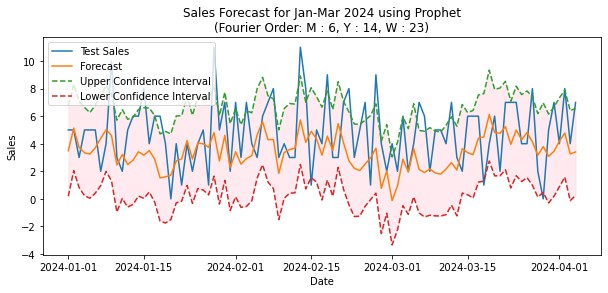

In [27]:
plot_prophet_test(origin_df, 122612, 88002798, 6, 14, 23)

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [41]:
def plot_prophet_upper_only(origin_df: pd.DataFrame, prst_no: int, item_cd: int, month_s=10, year_s=10, week_s=10): 
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    # 모델 마개조 여기서 시작
    model = Prophet(weekly_seasonality=week_s, yearly_seasonality=year_s, daily_seasonality=False)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=month_s)
    
    features = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'WEEKDAY', 
                'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
                'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7']
    
    for feature in features:
        if feature in train_prophet.columns:
            model.add_regressor(feature)

    model.fit(train_prophet)
    
    # 예측 설정
    future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    
    # 미래 데이터프레임에 추가 특성들 포함
    future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
    future_with_features = future_with_features.drop(columns=['YMD_CD'])
    
    forecast = model.predict(future_with_features)
    
    # 2024년도 데이터만 필터링
    filtered_test_2024 = filtered_test[filtered_test['YMD_CD'].dt.year == 2024]
    forecast_2024 = forecast[forecast['ds'].dt.year == 2024]
    
    # 예측 결과와 실제 값 병합
    comparison_df = pd.merge(filtered_test_2024, forecast_2024[['ds', 'yhat', 'yhat_upper']], left_on='YMD_CD', right_on='ds')
    
    # RMSE, MAE, NMAE 계산
    y_true = comparison_df['SALE_QTY']
    y_pred = comparison_df['yhat']
    y_upper = comparison_df['yhat_upper']
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    nmae = mae / np.mean(y_true)
    
    rmse_upper = np.sqrt(mean_squared_error(y_true, y_upper))
    mae_upper = mean_absolute_error(y_true, y_upper)
    nmae_upper = mae_upper / np.mean(y_true)
    
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'NMAE: {nmae:.2f}')
    
    print(f'RMSE (Upper): {rmse_upper:.2f}')
    print(f'MAE (Upper): {mae_upper:.2f}')
    print(f'NMAE (Upper): {nmae_upper:.2f}')
    
    # 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_test_2024['YMD_CD'], filtered_test_2024['SALE_QTY'], label='Test Sales')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat'], label='Forecast')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat_upper'], label='Upper Confidence Interval', linestyle='--')
    # plt.fill_between(forecast_2024['ds'], forecast_2024['yhat_upper'], alpha=0.3, color='pink')
    plt.title(f'Sales Forecast for Jan-Mar 2024 using Prophet\n(Fourier Order: M : {month_s}, Y : {year_s}, W : {week_s})')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

11:37:21 - cmdstanpy - INFO - Chain [1] start processing
11:37:21 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 2.70
MAE: 2.22
NMAE: 0.47
RMSE (Upper): 2.99
MAE (Upper): 2.40
NMAE (Upper): 0.50


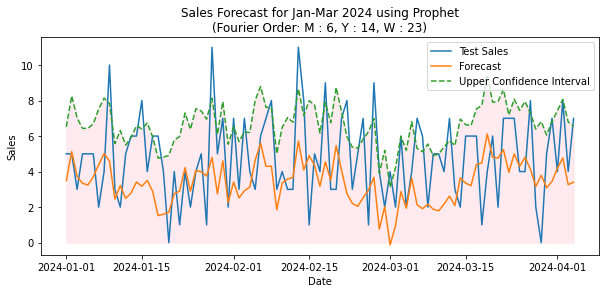

In [28]:
plot_prophet_upper_only(origin_df, 122612, 88002798, 6, 14, 23)

In [30]:
# 이터레이션 툴
from itertools import product

In [46]:
# 파라미터 그리드 설정
param_grid = {
    'yearly_seasonality': [1, 30],
    'weekly_seasonality': [1, 30],
    'monthly_seasonality': [1, 30]
}

# 가능한 파라미터 조합 생성
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

In [32]:
# 베스트 파라메터 찾기 함수
def find_best_params(origin_df, prst_no, item_cd, param_grid):
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
    
    best_params = None
    best_mae = float('inf')
    
    for params in all_params:
        model = Prophet(
            yearly_seasonality=params['yearly_seasonality'],
            weekly_seasonality=params['weekly_seasonality'],
            daily_seasonality=False
        )
        model.add_seasonality(name='monthly', period=30.5, fourier_order=params['monthly_seasonality'])
        
        features = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'WEEKDAY', 
                    'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
                    'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7']
        
        for feature in features:
            if feature in train_prophet.columns:
                model.add_regressor(feature)
        
        model.fit(train_prophet)
        
        future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
        future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
        future_with_features = future_with_features.drop(columns=['YMD_CD'])
        
        forecast = model.predict(future_with_features)
        
        y_pred = forecast['yhat'].iloc[-len(filtered_test):].values
        y_true = filtered_test['SALE_QTY'].values
        
        mae = mean_absolute_error(y_true, y_pred)
        
        if mae < best_mae:
            best_mae = mae
            best_params = params
    
    return best_params, best_mae


12:20:27 - cmdstanpy - INFO - Chain [1] start processing
12:20:27 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 2.70
MAE: 2.22
NMAE: 0.47
RMSE (Upper): 2.97
MAE (Upper): 2.41
NMAE (Upper): 0.51


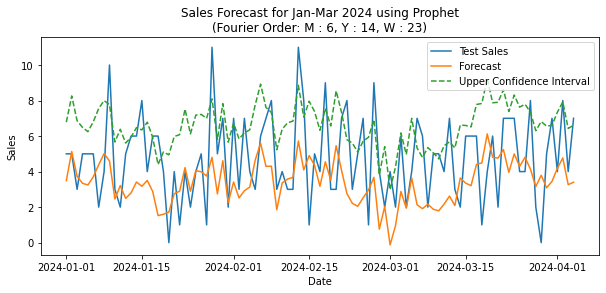

In [53]:
plot_prophet_upper_only(origin_df, 122612, 88002798, 6, 14, 23)

In [47]:
find_best_params(origin_df, 122612, 88002798, param_grid)

12:18:21 - cmdstanpy - INFO - Chain [1] start processing
12:18:21 - cmdstanpy - INFO - Chain [1] done processing
12:18:21 - cmdstanpy - INFO - Chain [1] start processing
12:18:21 - cmdstanpy - INFO - Chain [1] done processing
12:18:21 - cmdstanpy - INFO - Chain [1] start processing
12:18:21 - cmdstanpy - INFO - Chain [1] done processing
12:18:22 - cmdstanpy - INFO - Chain [1] start processing
12:18:22 - cmdstanpy - INFO - Chain [1] done processing
12:18:22 - cmdstanpy - INFO - Chain [1] start processing
12:18:22 - cmdstanpy - INFO - Chain [1] done processing
12:18:22 - cmdstanpy - INFO - Chain [1] start processing
12:18:22 - cmdstanpy - INFO - Chain [1] done processing
12:18:23 - cmdstanpy - INFO - Chain [1] start processing
12:18:23 - cmdstanpy - INFO - Chain [1] done processing
12:18:23 - cmdstanpy - INFO - Chain [1] start processing
12:18:23 - cmdstanpy - INFO - Chain [1] done processing


({'yearly_seasonality': 1, 'weekly_seasonality': 30, 'monthly_seasonality': 1},
 2.081761052482088)

In [48]:
# 카스캔
find_best_params(origin_df, 122612, 8801858011024, param_grid)

12:18:56 - cmdstanpy - INFO - Chain [1] start processing
12:18:56 - cmdstanpy - INFO - Chain [1] done processing
12:18:56 - cmdstanpy - INFO - Chain [1] start processing
12:18:56 - cmdstanpy - INFO - Chain [1] done processing
12:18:56 - cmdstanpy - INFO - Chain [1] start processing
12:18:56 - cmdstanpy - INFO - Chain [1] done processing
12:18:56 - cmdstanpy - INFO - Chain [1] start processing
12:18:57 - cmdstanpy - INFO - Chain [1] done processing
12:18:57 - cmdstanpy - INFO - Chain [1] start processing
12:18:57 - cmdstanpy - INFO - Chain [1] done processing
12:18:57 - cmdstanpy - INFO - Chain [1] start processing
12:18:57 - cmdstanpy - INFO - Chain [1] done processing
12:18:57 - cmdstanpy - INFO - Chain [1] start processing
12:18:57 - cmdstanpy - INFO - Chain [1] done processing
12:18:58 - cmdstanpy - INFO - Chain [1] start processing
12:18:58 - cmdstanpy - INFO - Chain [1] done processing


({'yearly_seasonality': 1, 'weekly_seasonality': 30, 'monthly_seasonality': 1},
 3.915318780070397)

12:22:19 - cmdstanpy - INFO - Chain [1] start processing
12:22:19 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 5.48
MAE: 4.58
NMAE: 0.61
RMSE (Upper): 8.33
MAE (Upper): 7.03
NMAE (Upper): 0.94


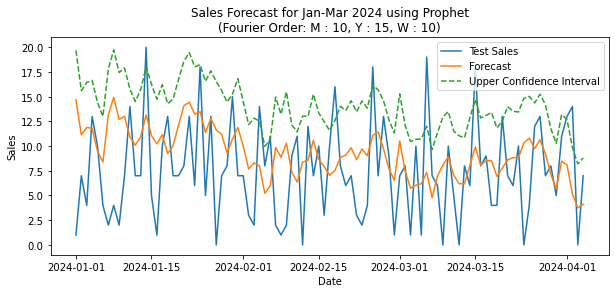

In [54]:
plot_prophet_upper_only(origin_df, 122612, 8801858011024, 10, 15, 10)

In [37]:
import matplotlib.pyplot as plt

def plot_prophet_upper_only(origin_df, prst_no, item_cd, month_s=10, year_s=10, week_s=10): 
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    model = Prophet(weekly_seasonality=week_s, yearly_seasonality=year_s, daily_seasonality=False)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=month_s)
    
    features = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'WEEKDAY', 
                'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
                'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7']
    
    for feature in features:
        if feature in train_prophet.columns:
            model.add_regressor(feature)

    model.fit(train_prophet)
    
    future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
    future_with_features = future_with_features.drop(columns=['YMD_CD'])
    
    forecast = model.predict(future_with_features)
    
    filtered_test_2024 = filtered_test[filtered_test['YMD_CD'].dt.year == 2024]
    forecast_2024 = forecast[forecast['ds'].dt.year == 2024]
    
    comparison_df = pd.merge(filtered_test_2024, forecast_2024[['ds', 'yhat', 'yhat_upper']], left_on='YMD_CD', right_on='ds')
    
    y_true = comparison_df['SALE_QTY']
    y_pred = comparison_df['yhat']
    y_upper = comparison_df['yhat_upper']
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    nmae = mae / np.mean(y_true)
    
    rmse_upper = np.sqrt(mean_squared_error(y_true, y_upper))
    mae_upper = mean_absolute_error(y_true, y_upper)
    nmae_upper = mae_upper / np.mean(y_true)
    
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'NMAE: {nmae:.2f}')
    
    print(f'RMSE (Upper): {rmse_upper:.2f}')
    print(f'MAE (Upper): {mae_upper:.2f}')
    print(f'NMAE (Upper): {nmae_upper:.2f}')
    
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_test_2024['YMD_CD'], filtered_test_2024['SALE_QTY'], label='Test Sales')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat'], label='Forecast')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat_upper'], label='Upper Confidence Interval', linestyle='--')
    plt.fill_between(forecast_2024['ds'], forecast_2024['yhat_upper'], alpha=0.3, color='pink')
    plt.title(f'Sales Forecast for Jan-Mar 2024 using Prophet\n(Fourier Order: M : {month_s}, Y : {year_s}, W : {week_s})')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()
